In [1]:
import os
import numpy as np
from tensorflow import keras as K
import cdUtils
from osgeo import gdal
from matplotlib import pyplot as plt

In [2]:
img_size = 128
cpt = 600
model_name = 'EF_'+str(img_size)+'_aug-'+str(cpt)
channels = 13

In [3]:
dataset_dir = '../CD_wOneraDataset/OneraDataset_Images/'
model_dir = 'models/'
f = 'beirut'
filter_dir = 'filter_samples/'

In [4]:
if not os.path.exists(filter_dir):
    os.mkdir(filter_dir)

In [5]:
raster1 = cdUtils.build_raster(dataset_dir + f + '/imgs_1_rect/', channels)
raster2 = cdUtils.build_raster(dataset_dir + f + '/imgs_2_rect/', channels)
raster = np.concatenate((raster1,raster2), axis=2)
padded_raster = cdUtils.pad(raster, img_size)
test_image = cdUtils.crop(padded_raster, img_size, img_size)

# Create inputs for the Neural Network
inputs = np.asarray(test_image, dtype='float32')

In [6]:
img_train = inputs[12]
img_train.dtype

dtype('float32')

In [7]:
redBand = img_train[:,:,3]
redMax = np.max(redBand.reshape(-1))
redBand /= redMax

In [8]:
greenBand = img_train[:,:,2]
greenMax = np.max(greenBand.reshape(-1))
greenBand /= greenMax

In [9]:
blueBand = img_train[:,:,1]
blueMax = np.max(blueBand.reshape(-1))
blueBand /= blueMax

In [16]:
rgb_image = np.stack([redBand,greenBand,blueBand],axis=2)
rgb_image.shape

(128, 128, 3)

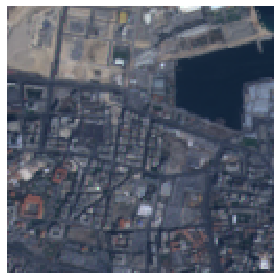

In [28]:
plt.imshow(rgb_image)
plt.axis('off')
plt.tight_layout()
plt.savefig(filter_dir+'input.pdf', format='pdf')

In [29]:
img_train = np.expand_dims(img_train, axis=0)
img_train.shape

(1, 128, 128, 26)

In [30]:
# Load model
model = K.models.load_model(model_dir + model_name + '.h5')
model.summary()

Model: "EarlyFusion-UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 26 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 128, 128, 32) 7520        input[0][0]                      
__________________________________________________________________________________________________
bn1_1 (BatchNormalization)      (None, 128, 128, 32) 128         conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 128, 128, 32) 9248        bn1_1[0][0]                      
___________________________________________________________________________________

In [31]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    print(i, layer.name, layer.output.shape)

0 input (None, 128, 128, 26)
1 conv1_1 (None, 128, 128, 32)
2 bn1_1 (None, 128, 128, 32)
3 conv1_2 (None, 128, 128, 32)
4 bn1_2 (None, 128, 128, 32)
5 resi1 (None, 128, 128, 32)
6 dropout1 (None, 128, 128, 32)
7 max_pooling2d (None, 64, 64, 32)
8 conv2_1 (None, 64, 64, 64)
9 bn2_1 (None, 64, 64, 64)
10 conv2_2 (None, 64, 64, 64)
11 bn2_2 (None, 64, 64, 64)
12 resi2 (None, 64, 64, 64)
13 dropout2 (None, 64, 64, 64)
14 max_pooling2d_1 (None, 32, 32, 64)
15 conv3_1 (None, 32, 32, 128)
16 bn3_1 (None, 32, 32, 128)
17 conv3_2 (None, 32, 32, 128)
18 bn3_2 (None, 32, 32, 128)
19 resi3 (None, 32, 32, 128)
20 dropout3 (None, 32, 32, 128)
21 max_pooling2d_2 (None, 16, 16, 128)
22 conv4_1 (None, 16, 16, 256)
23 bn4_1 (None, 16, 16, 256)
24 conv4_2 (None, 16, 16, 256)
25 bn4_2 (None, 16, 16, 256)
26 resi4 (None, 16, 16, 256)
27 dropout4 (None, 16, 16, 256)
28 max_pooling2d_3 (None, 8, 8, 256)
29 conv5_1 (None, 8, 8, 512)
30 bn5_1 (None, 8, 8, 512)
31 conv5_2 (None, 8, 8, 512)
32 bn5_2 (None, 8, 8,

In [117]:
# Select layer to visualize
k = 4

In [118]:
output_name = model.layers[k].name
print(output_name)

bn1_2


In [119]:
output_name_dir = filter_dir + output_name + '/'
if not os.path.exists(output_name_dir):
    os.mkdir(output_name_dir)

In [120]:
# redefine model to output right after the first hidden layer
model_filters = K.Model(inputs=model.inputs, outputs=model.layers[k].output)

In [121]:
feature_maps = model_filters.predict(img_train)

In [122]:
feature_maps.shape

(1, 128, 128, 32)

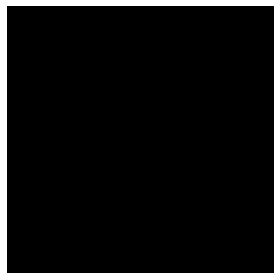

In [123]:
for n in range(feature_maps.shape[3]):
    plt.imshow(feature_maps[0, :, :, n], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    #plt.savefig(output_name_dir+'filter'+str(n)+'.pdf', format='pdf')

In [136]:
test = feature_maps[0, :, :, 4]
print(np.max(test.reshape(-1)))
print(np.min(test.reshape(-1)))

5.0352035
-0.82878953
